# Dataset: Customer segmentation 
### Cluster customers based on purchase behavior → Unsupervised clustering 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv("customers.csv")

print("Shape:", df.shape)
print(df.head())
print("\nDtypes:\n", df.dtypes)

Shape: (793, 5)
         id             name    segment           state             city
0  CG-12520      Claire Gute   Consumer        Kentucky        Henderson
1  DV-13045  Darrin Van Huff  Corporate      California      Los Angeles
2  SO-20335   Sean O'Donnell   Consumer         Florida  Fort Lauderdale
3  BH-11710  Brosina Hoffman   Consumer      California      Los Angeles
4  AA-10480     Andrew Allen   Consumer  North Carolina          Concord

Dtypes:
 id         object
name       object
segment    object
state      object
city       object
dtype: object


In [5]:
id_like_cols = [col for col in df.columns if "id" in col.lower() or "name" in col.lower() or "email" in col.lower()]
df_clean = df.drop(columns=id_like_cols, errors="ignore")

print("\nDropped:", id_like_cols)


Dropped: ['id', 'name']


In [6]:
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: []
Categorical columns: ['segment', 'state', 'city']


In [7]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [8]:
X_processed = preprocessor.fit_transform(df_clean)

print("\nProcessed data shape:", X_processed.shape)


Processed data shape: (793, 296)


In [9]:
K_range = range(2, 11)
inertia = []
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_processed)

    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_processed, labels))

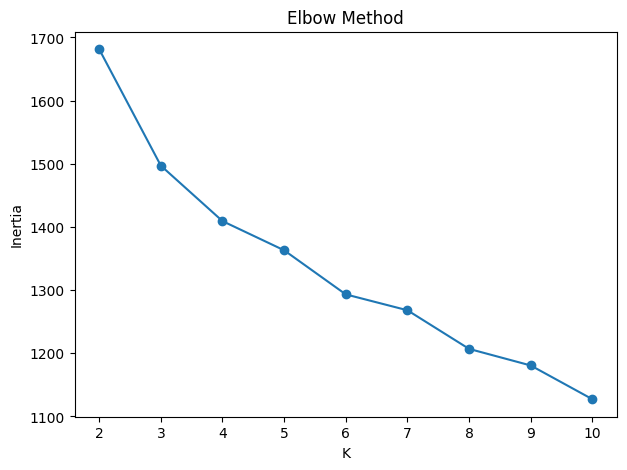

In [10]:
plt.figure(figsize=(7,5))
plt.plot(list(K_range), inertia, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

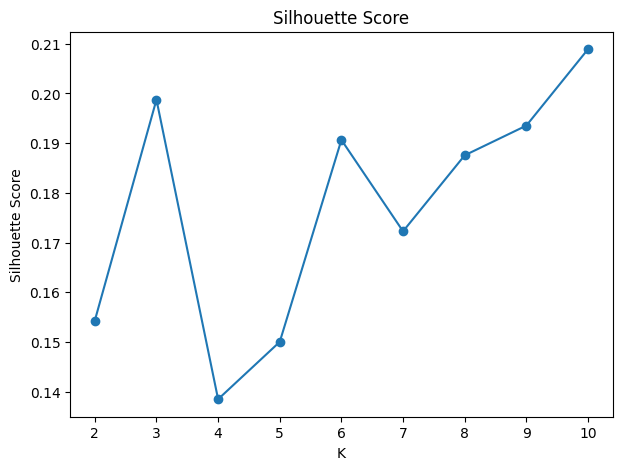

In [11]:
plt.figure(figsize=(7,5))
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

In [12]:
best_k = list(K_range)[np.argmax(sil_scores)]
print("\nBest K:", best_k)


Best K: 10


In [13]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_processed)

df["Cluster"] = clusters
print("\nCluster counts:\n", df["Cluster"].value_counts())


Cluster counts:
 Cluster
0    189
1    141
4    119
3     87
5     60
2     56
6     47
8     46
9     24
7     24
Name: count, dtype: int64


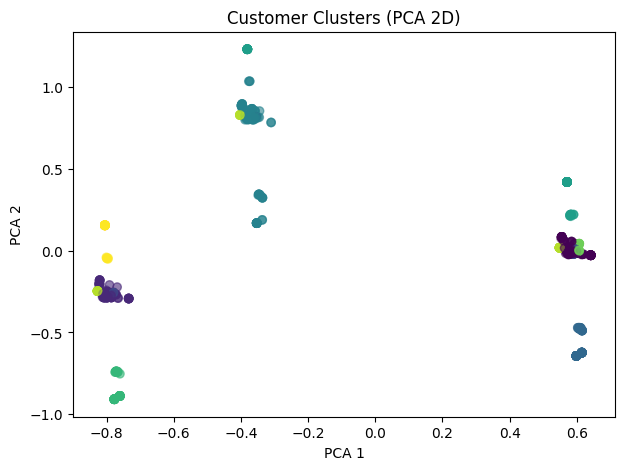

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Clusters (PCA 2D)")
plt.show()